This notebook is adapted from the official PyTorch tutorial on [Transfer Learning for Computer Vision](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) authored by [Sasank Chilamkurthy](https://chsasank.github.io).


# Transfer Learning for Computer Vision

In this tutorial, we will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

In general, a neural network pre-trained on large datasets is known as a [foundation model](https://arxiv.org/abs/2108.07258). One prominent example is the famous [BERT](https://arxiv.org/abs/1810.04805) model for natural language tasks.

With a foundation model, we can either

-  **finetune it**: instead of training a new, randomly initialized model, we start training with the weights provided by the foundation model; or
-  **use it as a fixed feature extractor**: we turn off autograd for all but the last layer's weights and train the last layer only. 

In either case, we often need to replace the last layer, which is usually a `nn.Linear` with `out_features` equal to the number of classes, with a new, randomly initialized `nn.Linear` that has the correct `out_features` for OUR task at hand. 


In [1]:
import torch
import torch.nn as nn
import torchvision

## Load Data

In contrast to the official tutorial, we will use the classic [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset in this notebook. Due to its importance in the development of modern deep learning, CIFAR-10 has earned a spot in [torchvision](https://pytorch.org/vision/0.14/), the official PyTorch package for computer vision tasks. 

All it means to us is that we can load CIFAR-10 from `torchvision` effortlessly. 

In [2]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Data pre-processing
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(),                                   # data augmentation
        transforms.ToTensor(),                                               # convert data to tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   # channel-wise data normalization
    ]),
    "test": transforms.Compose([ 
        # no data augmentation for test/val data
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

cifar10_train = CIFAR10(root=".", train=True,  transform=data_transforms["train"], download=True)
cifar10_test =  CIFAR10(root=".", train=False, transform=data_transforms["test"],  download=True)

Files already downloaded and verified
Files already downloaded and verified


A more complete list of image transforms can be found [here](https://pytorch.org/vision/0.14/transforms.html). 

In [3]:
from torch.utils.data import Dataset

isinstance(cifar10_train, Dataset) # cifar10_train is a Dataset

True

In [4]:
len(cifar10_train), len(cifar10_test)

(50000, 10000)

In [5]:
from torch.utils.data import random_split

cifar10_val, cifar10_test = random_split(cifar10_test, (5000, 5000), generator=torch.Generator().manual_seed(42))
len(cifar10_val), len(cifar10_test)

(5000, 5000)

We put the three datasets into `DataLoader`s right away. 



In [6]:
from torch.utils.data import DataLoader

dataloaders = {
    "train": DataLoader(cifar10_train, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True), 
    "val":   DataLoader(cifar10_val,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True), 
    "test":  DataLoader(cifar10_test,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True), 
}

# and keep a record of their lengths
dataset_sizes = {
    "train": len(cifar10_train), 
    "val":   len(cifar10_val), 
    "test":  len(cifar10_test)
}

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

In [8]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders["train"]))
inputs.size(), labels.size()

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [9]:
labels

tensor([6, 7, 7, 2, 5, 9, 4, 3, 9, 8, 2, 0, 1, 6, 6, 5, 9, 6, 4, 9, 9, 4, 2, 0,
        3, 4, 9, 9, 7, 8, 7, 7, 2, 5, 0, 8, 2, 4, 6, 5, 7, 9, 9, 8, 9, 0, 5, 8,
        4, 8, 3, 1, 1, 0, 0, 0, 6, 9, 4, 2, 8, 6, 5, 6, 5, 8, 9, 2, 8, 2, 0, 8,
        6, 7, 5, 8, 0, 7, 3, 9, 8, 6, 1, 8, 7, 8, 9, 0, 2, 9, 5, 2, 2, 3, 4, 0,
        1, 7, 7, 4, 4, 0, 6, 5, 4, 7, 1, 4, 6, 4, 0, 7, 5, 1, 7, 3, 9, 7, 0, 1,
        2, 9, 2, 7, 1, 9, 8, 0])

In [10]:
# A nice map from classes to numerical labels
cifar10_train.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    inp = inp.permute([1, 2, 0])
    inp = torch.clip(std * inp + mean, 0, 1)
    inp = inp.numpy()

    plt.figure(figsize=(8, 6))
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

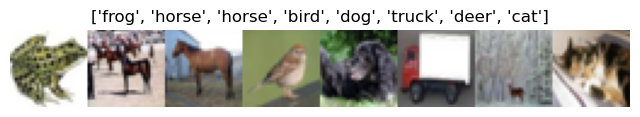

In [12]:
from torchvision.utils import make_grid

# Make a grid from batch
num_imgs = 8

out = make_grid(inputs[:num_imgs], padding=0)

class_names = list(cifar10_train.class_to_idx.keys())
imshow(out, title=[class_names[x] for x in labels[:num_imgs]])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate

-  scheduling the learning rate; and
-  saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [27]:
import copy
import time


def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    since = time.time() # start the timer

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                preds = torch.argmax(outputs, dim=1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
            
            # invoke your LR scheduler here if the LR is to be adjusted every EPOCH
            # if the LR is to be adjusted every STEP, left-indent this snippet
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [28]:
def visualize_model(model, num_images=8):
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu()[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning a ConvNet

Remember for finetuning a model, we start training with the weights provided by the model and reset the last fully connected layer (`nn.Linear`) to suit our problem. 

We can easily load a popular, pre-trained vision model from [torchvision.models](https://pytorch.org/vision/stable/models.html). 


In [29]:
model_ft = torchvision.models.resnet18(weights="IMAGENET1K_V1")

Let's print out the model architecture and understand better what we need to do with the last linear layer. 

In [30]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The last layer


```
(fc): Linear(in_features=512, out_features=1000, bias=True)
```

is a linear classifier that maps hidden features of 512 dimensions (`in_features=512`) to unnormalized probabilities for each of the 1000 classes (`out_features=1000`). 

We can't change the dimension of the hidden features (`in_features`), but we can and should change `out_features` so that it is equal to the number of classes in our own problem. That means we need to replace `model_ft.fc` with a new `nn.Linear` layer. 


In [31]:
num_feats = model_ft.fc.in_features
model_ft.fc = nn.Linear(in_features=num_feats, out_features=10) # we know we have 10 classes

In [32]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()

# Observe that ALL parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate




In [33]:
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


train Loss: 1.1575 Acc: 0.5930
val Loss: 0.8292 Acc: 0.7090

Epoch 1/4
----------
train Loss: 0.7266 Acc: 0.7458
val Loss: 0.7017 Acc: 0.7520

Epoch 2/4
----------
train Loss: 0.5839 Acc: 0.7969
val Loss: 0.6487 Acc: 0.7748

Epoch 3/4
----------
train Loss: 0.5014 Acc: 0.8237
val Loss: 0.6118 Acc: 0.7866

Epoch 4/4
----------
train Loss: 0.4299 Acc: 0.8516
val Loss: 0.6035 Acc: 0.7908

Training complete in 58m 27s
Best val Acc: 0.790800


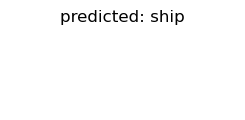

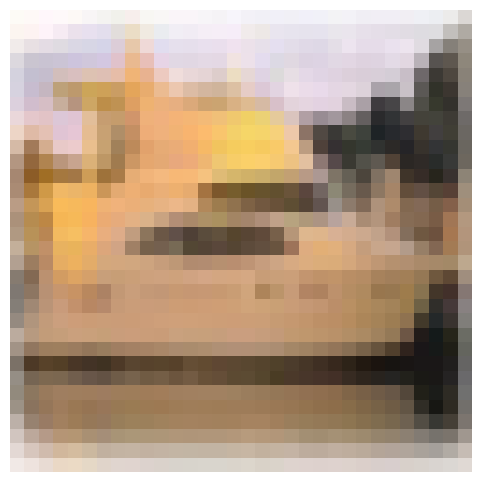

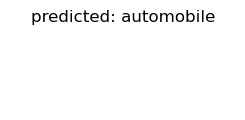

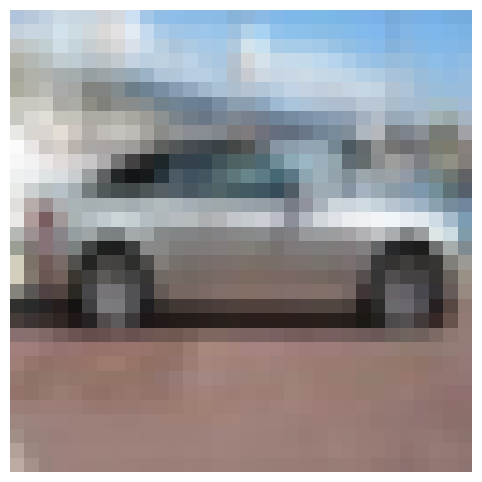

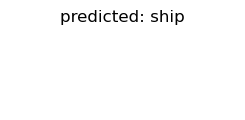

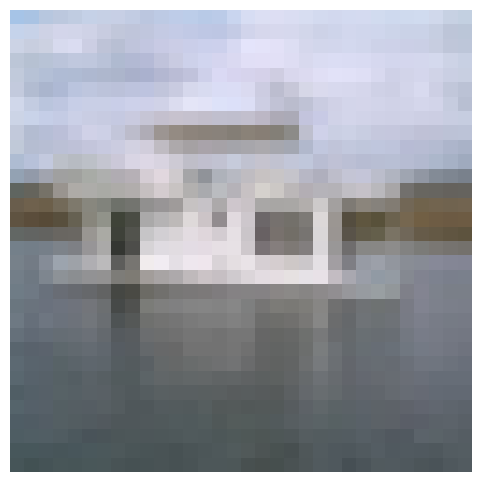

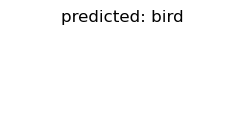

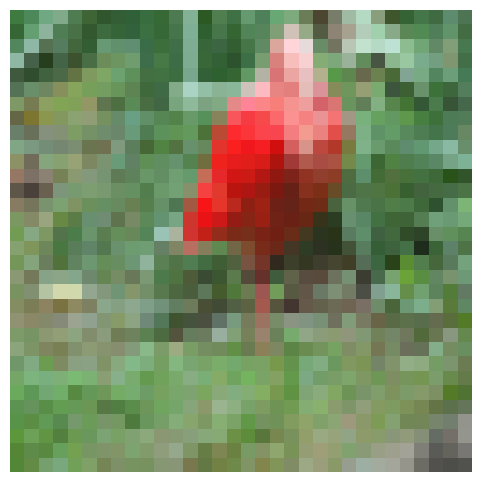

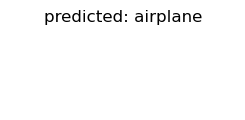

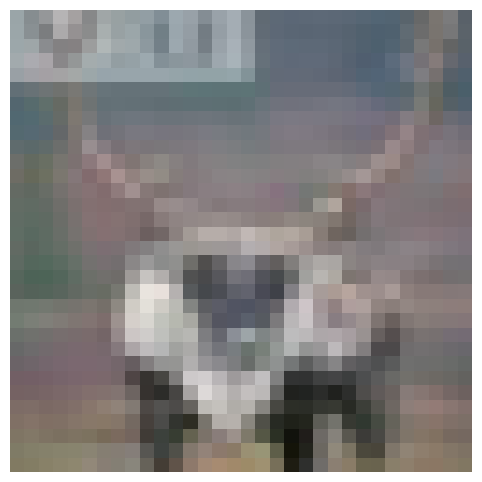

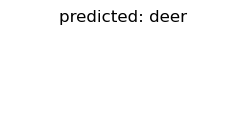

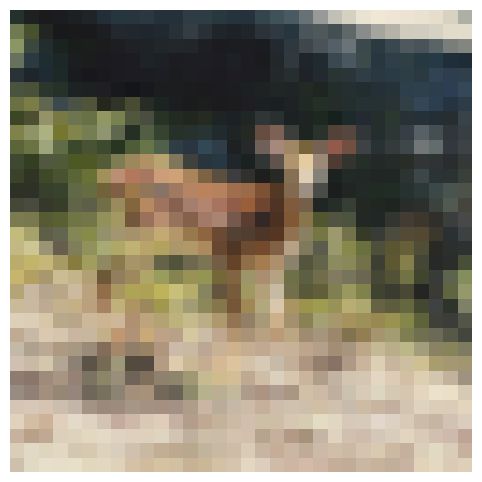

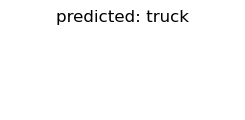

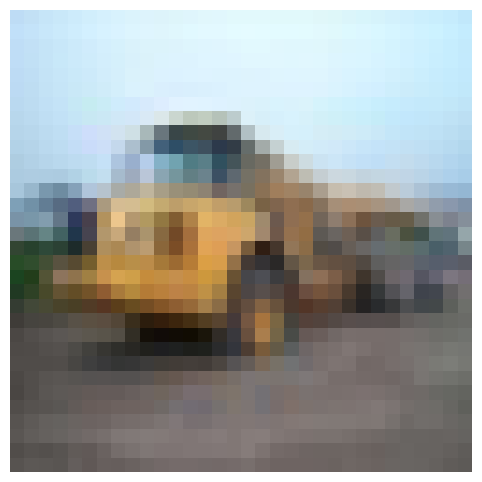

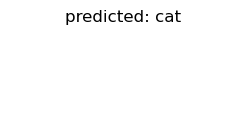

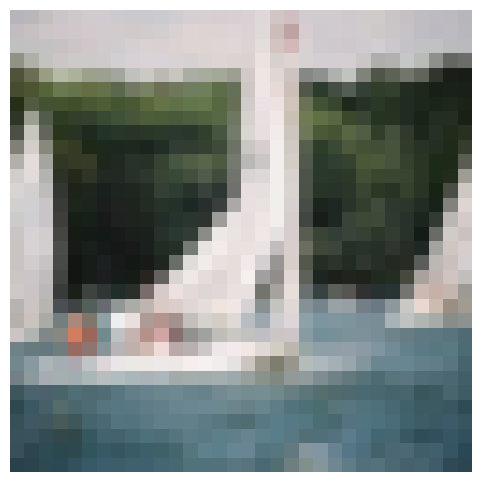

In [34]:
visualize_model(model_ft)

## Using ConvNet as fixed feature extractor

Here, we need to *freeze* all parts of the network except the last layer. More specifically, we need
to set ``requires_grad=False`` for all parameters in our model so that no gradients are computed for them during ``loss.backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/master/notes/autograd.html#setting-requires-grad).




In [35]:
# load the pre-trained model as before
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")

# freeze the parameters
for param in model_conv.parameters():
    param.requires_grad = False

# OR
# model_conv.requires_grad_(False)

# reset the last linear layer as before
# note that parameters of newly constructed modules have requires_grad=True by default
num_feats = model_conv.fc.in_features
model_conv.fc = nn.Linear(in_features=num_feats, out_features=10)

In [36]:
loss_fn = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate





In [37]:
model_conv = train_model(model_conv, loss_fn, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


train Loss: 1.8579 Acc: 0.3550
val Loss: 1.6881 Acc: 0.4314

Epoch 1/4
----------
train Loss: 1.6367 Acc: 0.4347
val Loss: 1.6123 Acc: 0.4502

Epoch 2/4
----------
train Loss: 1.5927 Acc: 0.4490
val Loss: 1.5949 Acc: 0.4532

Epoch 3/4
----------
train Loss: 1.5652 Acc: 0.4592
val Loss: 1.5695 Acc: 0.4640

Epoch 4/4
----------
train Loss: 1.5491 Acc: 0.4615
val Loss: 1.5615 Acc: 0.4696

Training complete in 10m 31s
Best val Acc: 0.469600


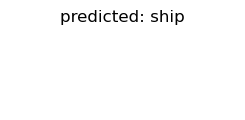

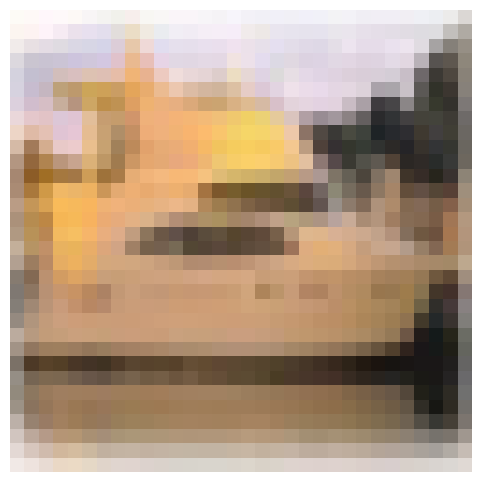

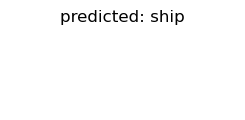

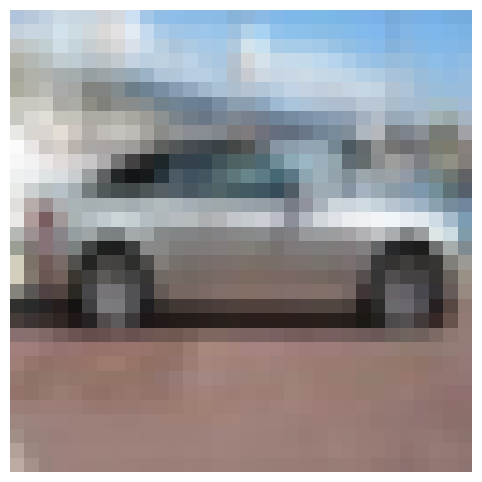

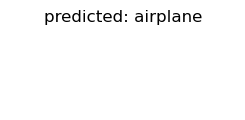

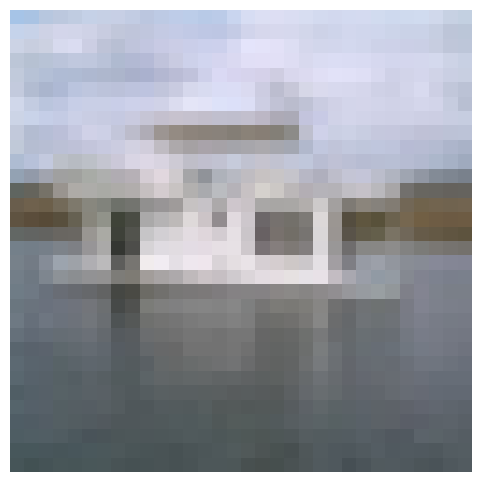

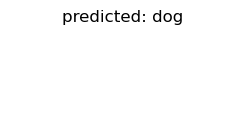

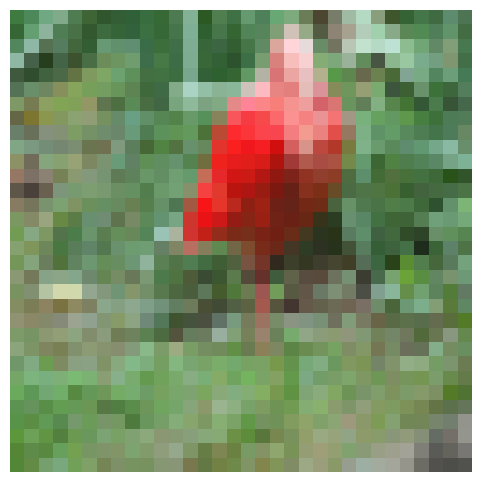

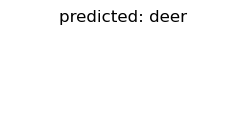

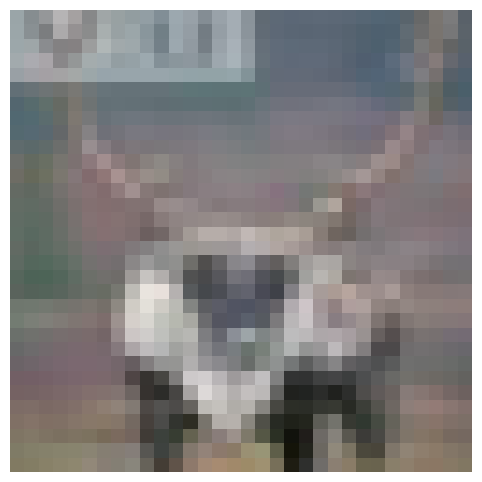

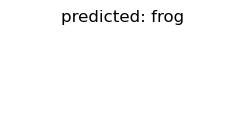

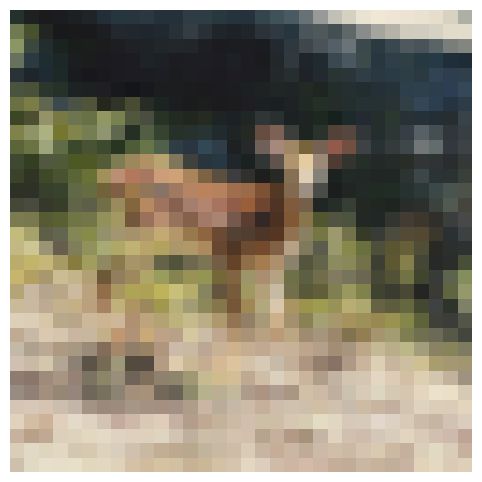

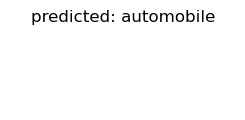

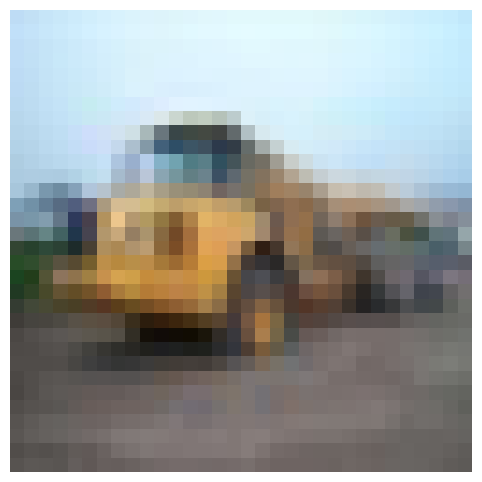

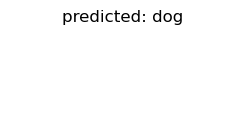

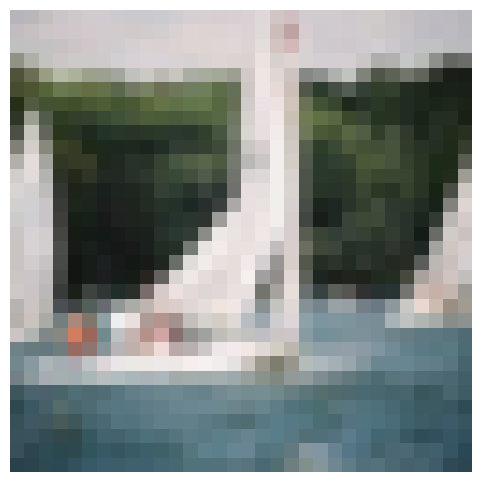

In [38]:
visualize_model(model_conv)

plt.ioff()
plt.show()